# 文本向量(Embedding)
文本向量，是指将一段文本，转化为一定维度的向量（文心百中语义模型中为384维），其中相近语义、相关主题的文本在向量空间更接近。拥有一个良好的文本嵌入特征，对于文本可视化、检索、聚类、内容审核等下游任务，有着重要的意义。

ERNIE Bot SDK提供用于生成文本的向量表示的ernie-text-embedding模型。

该模型基于文心大模型，使用海量数据训练得到，为文心百中系统提供关键能力。该模型可以将输入文本转为384维浮点数表示的向量。这些向量具备精准的语义表达能力，可用于度量文本之间的语义相似度。

使用前，请参考[认证鉴权文档](../../docs/authentication.md)获取要使用的后端的鉴权参数并将其配置为环境变量或者直接指定使用。

In [6]:
import time,math,erniebot,os
from typing import List
erniebot.api_type = 'aistudio'
erniebot.access_token = '<eb-access-token>'

## 1. API文档以及调用
此文档仅简单介绍相关参数，详情请见[API文档](../docs/api_reference/embedding.md)

Python接口
```python
erniebot.Embedding.create(**kwargs: Any)
    -> Union[EBResponse, Iterator[EBResponse]]
```

输入参数
| 参数名 | 类型 | 必填 | 描述 |
| :--- | :--- | :------- | :---- |
| model  | str | 是 | 模型名称。当前支持`'ernie-text-embedding'`。 |
| input | list[str] | 是 | 输入的文本列表，列表中每个元素为一段单独的文本。注意： <br>(1) 列表长度有最大限制。对于ernie-text-embedding模型，列表长度不能超过16。 <br>(2) 每段文本的token数量有最大限制，超出限制则报错（采用`汉字数 + 单词数 * 1.3`估算token数量）。对于ernie-text-embedding模型，每段文本支持最多**384个token**。 <br>(3) 文本内容不能为空。 |
| user_id | str | 否 | 终端用户的唯一标识符，可以监视和检测滥用行为，防止接口被恶意调用。 |

## 2. Embedding获取

**目前API接口可接受的batch_size单次最多支持16个，推荐使用以下函数进行调用，每段文本最多支持384token，后续会完善长文本切割函数使用。**

In [3]:
def get_embedding(word: List[str]) -> List[float]:
    if len(word) <= 16:
        embedding = erniebot.Embedding.create(
                                            model = 'ernie-text-embedding',
                                            input = word
                                            ).get_result()
    else:
        size = len(word)
        embedding = []
        for i in range(math.ceil(size / 16)):
            embedding.extend(erniebot.Embedding.create(model = 'ernie-text-embedding', input = word[i*16:(i+1)*16]).get_result())
            time.sleep(1) # 防止访问频繁报错
    return embedding

In [4]:
word = ['中国', '北京', '美国', '华盛顿特区', '巴西', '巴西利亚', '俄罗斯', '莫斯科', '法国', '巴黎', '英国', '伦敦', '日本', '东京', '德国', '柏林']
return_embedding = get_embedding(word)
print(f"已返回{len(return_embedding)}个语义向量")

已返回16个语义向量


## 3. 效果评测——向量相似度可视化
我们使用部分国家以及其首都来测试Embedding的效果，使用TSNE进行降维可视化。

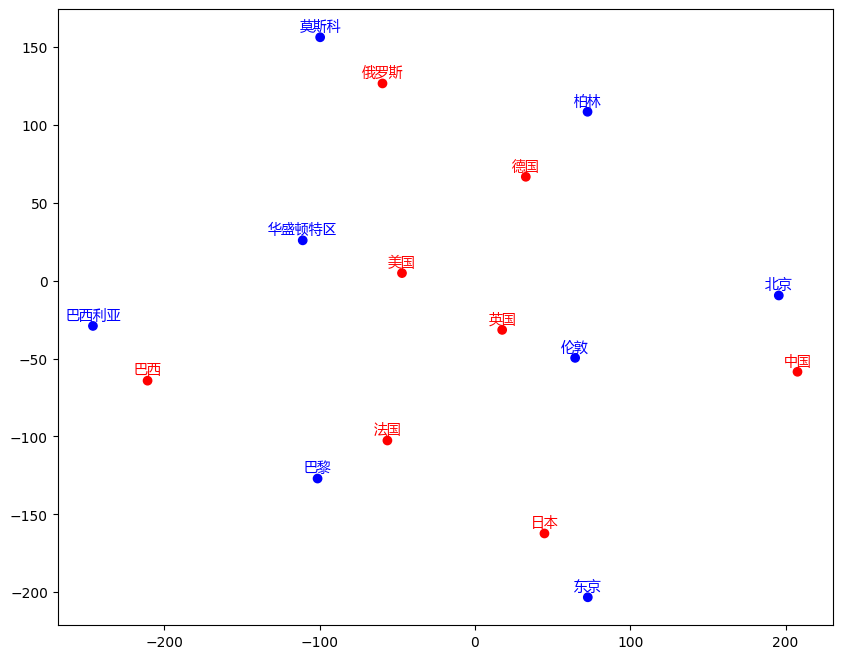

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties

chinese_font = FontProperties(fname="./微软雅黑.ttf")
def tsne_plot(
        word: List[str],
        embedding: List[float]):
    "Creates and TSNE model and plots it"
    embedding = np.array(embedding)
    
    tsne = TSNE(n_components=2, random_state=0,perplexity=7)
    embedded_vectors = tsne.fit_transform(embedding)

    plt.figure(figsize=(10, 8))
    colors = []
    for i in range(len(word)):
        
        colors.append('r' if i % 2 == 0 else 'b')
    plt.scatter(embedded_vectors[:, 0], embedded_vectors[:, 1], c = colors)

    for i, label in enumerate(word):
        x, y = embedded_vectors[i]
        plt.annotate(label, (x, y), textcoords='offset points', xytext=(0, 5), ha='center',fontproperties = chinese_font,
                     color='r' if i % 2 == 0 else 'b')
    plt.show()
tsne_plot(word,return_embedding)

## 4. Embedding应用

所有的应用例子都可以在notebook中体验：

[文本的模糊搜索](./embedding_apply/search.ipynb)

[文本聚类](./embedding_apply/cluster.ipynb)

[机器学习文本分类](./embedding_apply/ML_classification.ipynb) 使用文心大模型产生一定的训练数据，然后使用Embedding的特征直接进行文本分类任务。